<a href="https://colab.research.google.com/github/adamoosya/182Proj/blob/main/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import pickle

In [17]:
torch.manual_seed(1337)

# Download modules

In [ ]:
url = f"https://raw.githubusercontent.com/adamoosya/182Proj/main/hyperparameters.py"
!wget --no-cache --backups=1 {url}

url = f"https://raw.githubusercontent.com/adamoosya/182Proj/main/tokenizer.py"
!wget --no-cache --backups=1 {url}

url = f"https://raw.githubusercontent.com/adamoosya/182Proj/main/dataloader.py"
!wget --no-cache --backups=1 {url}

url = f"https://raw.githubusercontent.com/adamoosya/182Proj/main/model.py"
!wget --no-cache --backups=1 {url}

url = f"https://raw.githubusercontent.com/adamoosya/182Proj/main/data.py"
!wget --no-cache --backups=1 {url}

--2025-05-08 22:39:24--  https://raw.githubusercontent.com/adamoosya/182Proj/main/hyperparameters.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3279 (3.2K) [text/plain]
Saving to: ‘hyperparameters.py’

hyperparameters.py  100%[===================>]   3.20K  --.-KB/s    in 0s      

2025-05-08 22:39:24 (23.7 MB/s) - ‘hyperparameters.py’ saved [3279/3279]

--2025-05-08 22:39:24--  https://raw.githubusercontent.com/adamoosya/182Proj/main/tokenizer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

In [18]:
from hyperparameters import BATCH_SIZE, BLOCK_SIZE, MAX_ITERS, EVAL_INTERVAL, LEARNING_RATE, EVAL_ITERS, N_EMBD, N_HEAD, \
  N_LAYER, DROPOUT, DEVICE, DATA_CATEGORIES, TRAIN_DATA_CATEGORIES, VAL_DATA_CATEGORIES
from tokenizer import tokenize, detokenize, IS_TO_TOKEN, AS_TOKEN, END_TOKEN, VOCAB_SIZE, CHAR_TO_TOKEN, TOKEN_TO_CHAR
from dataloader import get_context_test, get_context_example, get_batch
from model import estimate_loss, GPTLanguageModel
from data import load_data

# Get morphological transformations

In [4]:
DATA, TRAIN_DATA, VAL_DATA = load_data()

--2025-05-08 22:39:31--  https://raw.githubusercontent.com/adamoosya/182Proj/main/data/singular_to_plural.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21382 (21K) [text/plain]
Saving to: ‘data/singular_to_plural.csv’

     0K .......... ..........                                 100% 68.0M=0s

2025-05-08 22:39:32 (68.0 MB/s) - ‘data/singular_to_plural.csv’ saved [21382/21382]

--2025-05-08 22:39:32--  https://raw.githubusercontent.com/adamoosya/182Proj/main/data/present_tense_to_past_tense.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP 

# Setup Model

In [20]:
def evaluate(model, dataset, category=None, num_to_evaluate=100):
    correct = 0
    total = 0
    model.eval()
    for _ in range(num_to_evaluate):
        context, target = get_context_test(dataset, category=category)
        if model.test(context, target):
            correct += 1
        total += 1
    model.train()
    return correct / total

In [6]:
model = GPTLanguageModel()
model = model.to(DEVICE)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

10.762783 M parameters


# Train Model

In [ ]:
for iter in range(MAX_ITERS):

    # every once in a while evaluate the loss on train and val sets
    if iter % EVAL_INTERVAL == EVAL_INTERVAL-1:

      train_score = evaluate(model, TRAIN_DATA, category=None)
      print(f"Epoch: {iter}, Train Score: {train_score:.4f}")

      val_score = evaluate(model, VAL_DATA, category=None)
      print(f"Epoch: {iter}, Validation Score: {val_score:.4f}")

      checkpoint_name = f"epoch_{iter+1:04d}.pth"  # Format with leading zeros
      torch.save(model.state_dict(), os.path.join("checkpoint", checkpoint_name))

    # sample a batch of data
    xb, yb, mask = get_batch(TRAIN_DATA)

    # evaluate the loss
    logits, loss = model(xb, yb, mask)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

Epoch: 499, Train Score: 0.3800
Epoch: 499, Validation Score: 0.2100
Epoch: 999, Train Score: 0.3100
Epoch: 999, Validation Score: 0.3000
Epoch: 1499, Train Score: 0.5300
Epoch: 1499, Validation Score: 0.3600
Epoch: 1999, Train Score: 0.5500
Epoch: 1999, Validation Score: 0.3400
Epoch: 2499, Train Score: 0.4900
Epoch: 2499, Validation Score: 0.3800
Epoch: 2999, Train Score: 0.5300
Epoch: 2999, Validation Score: 0.3000
Epoch: 3499, Train Score: 0.5600
Epoch: 3499, Validation Score: 0.3900
Epoch: 3999, Train Score: 0.6500
Epoch: 3999, Validation Score: 0.5100
Epoch: 4499, Train Score: 0.5700
Epoch: 4499, Validation Score: 0.5100
Epoch: 4999, Train Score: 0.6400
Epoch: 4999, Validation Score: 0.5000


# Download model checkpoints

In [7]:
if not os.path.exists("checkpoint"):
    os.makedirs("checkpoint")

checkpoints = [
    "epoch_0500.pth",
    "epoch_1000.pth",
    "epoch_1500.pth",
    "epoch_2000.pth",
    "epoch_2500.pth",
    "epoch_3000.pth",
    "epoch_3500.pth",
    "epoch_4000.pth",
    "epoch_4500.pth",
    "epoch_5000.pth",
]

for checkpoint in checkpoints:
    url = f"https://raw.githubusercontent.com/adamoosya/182Proj/main/checkpoint/{checkpoint}"
    !wget --no-cache --backups=1 -O checkpoint/{checkpoint} {url}


--2025-05-04 21:52:58--  https://raw.githubusercontent.com/adamoosya/182Proj/main/checkpoint/epoch_0500.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52567888 (50M) [application/octet-stream]
Saving to: ‘checkpoint/epoch_0500.pth’

checkpoint/epoch_05 100%[===================>]  50.13M  --.-KB/s    in 0.1s    

2025-05-04 21:53:03 (501 MB/s) - ‘checkpoint/epoch_0500.pth’ saved [52567888/52567888]

--2025-05-04 21:53:03--  https://raw.githubusercontent.com/adamoosya/182Proj/main/checkpoint/epoch_1000.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting 

# Generate loss/accuracy data

In [13]:
losses = {
    'train': {category: [] for category in TRAIN_DATA_CATEGORIES},
    'val': {category: [] for category in VAL_DATA_CATEGORIES}
}
accuracies = {
    'train': {category: [] for category in TRAIN_DATA_CATEGORIES},
    'val': {category: [] for category in VAL_DATA_CATEGORIES}
}

losses['train'][None] = []
accuracies['train'][None] = []
losses['val'][None] = []
accuracies['val'][None] = []

In [14]:
checkpoint_dir = "checkpoint"
checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")]
checkpoints.sort()

for checkpoint_name in checkpoints:
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    print(f"Loading checkpoint: {checkpoint_name}")
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    for split, dataset in zip(losses, [TRAIN_DATA, VAL_DATA]):
        for category in losses[split]:
            losses[split][category].append(estimate_loss(model, dataset, category))
            accuracies[split][category].append(evaluate(model, dataset, category))

Loading checkpoint: epoch_0500.pth
Loading checkpoint: epoch_1000.pth
Loading checkpoint: epoch_1500.pth
Loading checkpoint: epoch_2000.pth
Loading checkpoint: epoch_2500.pth
Loading checkpoint: epoch_3000.pth
Loading checkpoint: epoch_3500.pth
Loading checkpoint: epoch_4000.pth
Loading checkpoint: epoch_4500.pth
Loading checkpoint: epoch_5000.pth


In [15]:
with open('losses.pkl', 'wb') as f:
    pickle.dump(losses, f)

with open('accuracies.pkl', 'wb') as f:
    pickle.dump(accuracies, f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

True
True


#Load loss/accuracy data

In [58]:
!wget --no-cache --backups=1 https://raw.githubusercontent.com/adamoosya/182Proj/main/checkpoint/losses.pkl
!wget --no-cache --backups=1 https://raw.githubusercontent.com/adamoosya/182Proj/main/checkpoint/accuracies.pkl

with open('losses.pkl', 'rb') as f:
    losses = pickle.load(f)

with open('accuracies.pkl', 'rb') as f:
    accuracies = pickle.load(f)


--2025-05-05 04:44:51--  https://raw.githubusercontent.com/adamoosya/182Proj/main/checkpoint/losses.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95700 (93K) [application/octet-stream]
Saving to: ‘losses.pkl’


losses.pkl            0%[                    ]       0  --.-KB/s               
losses.pkl          100%[===================>]  93.46K  --.-KB/s    in 0.02s   

2025-05-05 04:44:51 (3.80 MB/s) - ‘losses.pkl’ saved [95700/95700]

--2025-05-05 04:44:52--  https://raw.githubusercontent.com/adamoosya/182Proj/main/checkpoint/accuracies.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 

#Load model from checkpoint and test

In [7]:
if not os.path.exists("checkpoint"):
    os.makedirs("checkpoint")

checkpoint = 'epoch_5000.pth'

url = f"https://raw.githubusercontent.com/adamoosya/182Proj/main/checkpoint/{checkpoint}"
!wget --no-cache --backups=1 -O checkpoint/{checkpoint} {url}

--2025-05-08 22:40:04--  https://raw.githubusercontent.com/adamoosya/182Proj/main/checkpoint/epoch_5000.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52567888 (50M) [application/octet-stream]
Saving to: ‘checkpoint/epoch_5000.pth’

checkpoint/epoch_50 100%[===================>]  50.13M  50.1MB/s    in 1.0s    

2025-05-08 22:40:06 (50.1 MB/s) - ‘checkpoint/epoch_5000.pth’ saved [52567888/52567888]



In [29]:
model = GPTLanguageModel()
model = model.to(DEVICE)
model.load_state_dict(torch.load('checkpoint/' + checkpoint, map_location=DEVICE))
model.eval()


GPTLanguageModel(
  (token_embedding_table): Embedding(31, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=384, out_features=64, bias=False)
            (query): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine

In [30]:
context, target = get_context_test(VAL_DATA, category=None)
target += '@'
model.test(context, target, output=True)

Context: sighed#had sighed$entertained#, Prediction: unentertained@y@, Expected: had entertained@


False

In [31]:
evaluate(model, VAL_DATA, num_to_evaluate=1000)

0.507

In [174]:
context, target = 'clad#unclad$victory#', 'defeat@@@@@@'
model.test(context, target, output=True)

Context: clad#unclad$victory#, Prediction: unvictory@@@, Expected: defeat@@@@@@


False

# Create loss/accuracy graphs

<ipython-input-74-fdd48754cf66>:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{tick*500:.2f}' for tick in x_ticks])


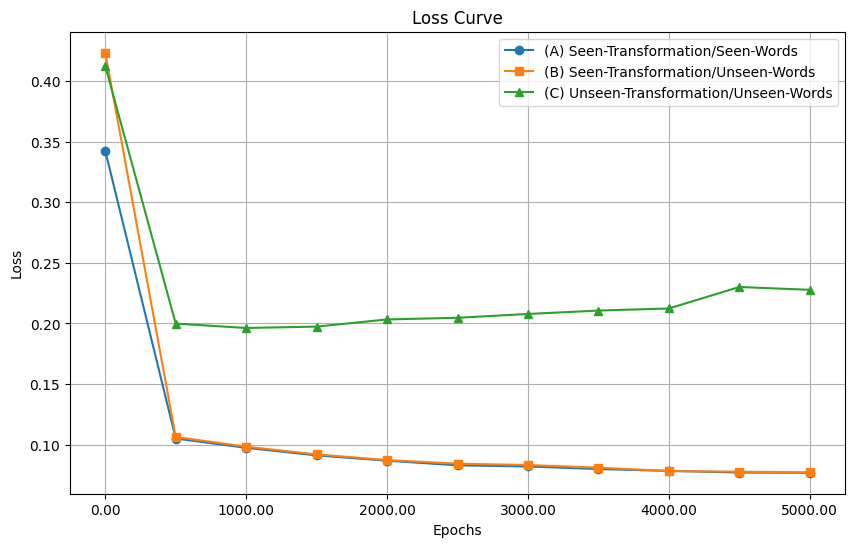

In [74]:
# prompt: For the validation losses in TRAIN_DATA_CATEGORIES, i want you to average all of them together to create a new list with their averages. Then, for all of the validation losses in [BASE_TO_PAST_PARTICIPLE,
#     SIMPLE_PAST_TO_PAST_PERFECT,
#     AFFIRMATIVE_TO_NEGATIVE], I want you to average those together as well. Then, create a plot with the losses['train'][None], and those two plots. Label them (A), (B), and (C). The x axis should say "Loss", and the Y axis should say "Epochs". The y axis should be multiplied by 500 so that it is of length 5000.

import matplotlib.pyplot as plt

A = losses['train'][None].copy()
B = []
for i in range(10):
  avg = 0
  for category in TRAIN_DATA_CATEGORIES:
    avg += losses['val'][category][i].numpy()

  avg /= len(TRAIN_DATA_CATEGORIES)
  B.append(avg)

C = []
# Calculate average validation losses for specified categories
categories_to_average = [
    'base_to_past_participle',
    'simple_past_to_past_perfect',
    'affirmative_to_negative'
]

for i in range(10):
  avg = 0
  for category in categories_to_average:
    avg += losses['val'][category][i].numpy()

  avg /= len(categories_to_average)
  C.append(avg)

A.insert(0, 0.34256)
B.insert(0, 0.42346)
C.insert(0, 0.4126)

# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(A, label='(A) Seen-Transformation/Seen-Words', marker='o')
plt.plot(B, label='(B) Seen-Transformation/Unseen-Words', marker='s')
plt.plot(C, label='(C) Unseen-Transformation/Unseen-Words', marker='^')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Multiply y-axis values by 500
x_ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{tick*500:.2f}' for tick in x_ticks])

plt.show()


[0.16, 0.23, 0.2, 0.26, 0.23, 0.32, 0.2, 0.3, 0.33, 0.26]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.11, 0.07, 0.07, 0.12, 0.12, 0.17, 0.11, 0.09, 0.14, 0.15]
[0.09000000000000001, 0.10000000000000002, 0.09000000000000001, 0.12666666666666668, 0.11666666666666665, 0.16333333333333333, 0.10333333333333333, 0.13, 0.15666666666666668, 0.1366666666666667]


<ipython-input-78-ef706eab4744>:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f'{tick*500:.2f}' for tick in x_ticks])


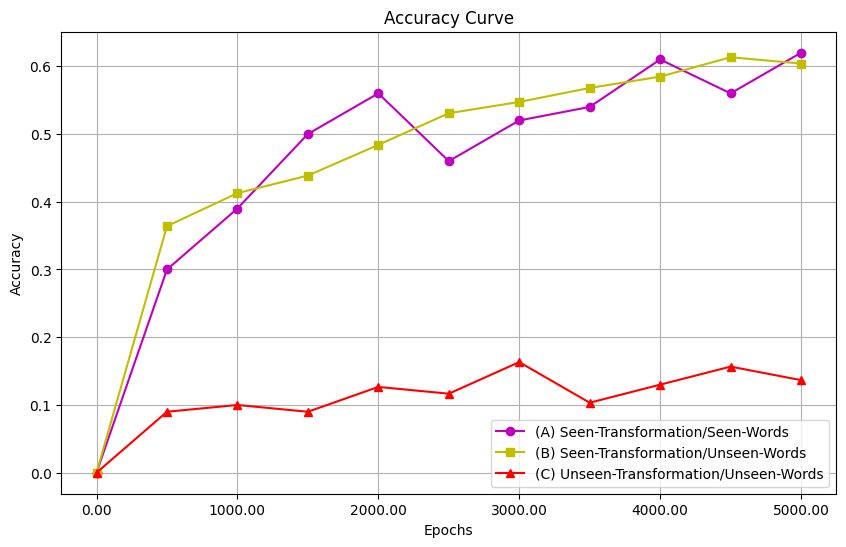

In [78]:
# prompt: For the validation losses in TRAIN_DATA_CATEGORIES, i want you to average all of them together to create a new list with their averages. Then, for all of the validation losses in [BASE_TO_PAST_PARTICIPLE,
#     SIMPLE_PAST_TO_PAST_PERFECT,
#     AFFIRMATIVE_TO_NEGATIVE], I want you to average those together as well. Then, create a plot with the losses['train'][None], and those two plots. Label them (A), (B), and (C). The x axis should say "Loss", and the Y axis should say "Epochs". The y axis should be multiplied by 500 so that it is of length 5000.

import matplotlib.pyplot as plt

A = accuracies['train'][None].copy()
B = []
for i in range(10):
  avg = 0
  for category in TRAIN_DATA_CATEGORIES:
    avg += accuracies['val'][category][i]

  avg /= len(TRAIN_DATA_CATEGORIES)
  B.append(avg)

for category in categories_to_average:
  print(accuracies['val'][category])

C = []
# Calculate average validation losses for specified categories
categories_to_average = [
    'base_to_past_participle',
    'simple_past_to_past_perfect',
    'affirmative_to_negative'
]

for i in range(10):
  avg = 0
  for category in categories_to_average:
    avg += accuracies['val'][category][i]

  avg /= len(categories_to_average)
  C.append(avg)

print(C)
A.insert(0, 0)
B.insert(0, 0)
C.insert(0, 0)
# Create the plot
plt.figure(figsize=(10, 6))

plt.plot(A, label='(A) Seen-Transformation/Seen-Words', marker='o',  color='m')
plt.plot(B, label='(B) Seen-Transformation/Unseen-Words', marker='s', color='y')
plt.plot(C, label='(C) Unseen-Transformation/Unseen-Words', marker='^',  color='r')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

# Multiply y-axis values by 500
x_ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{tick*500:.2f}' for tick in x_ticks])

plt.show()


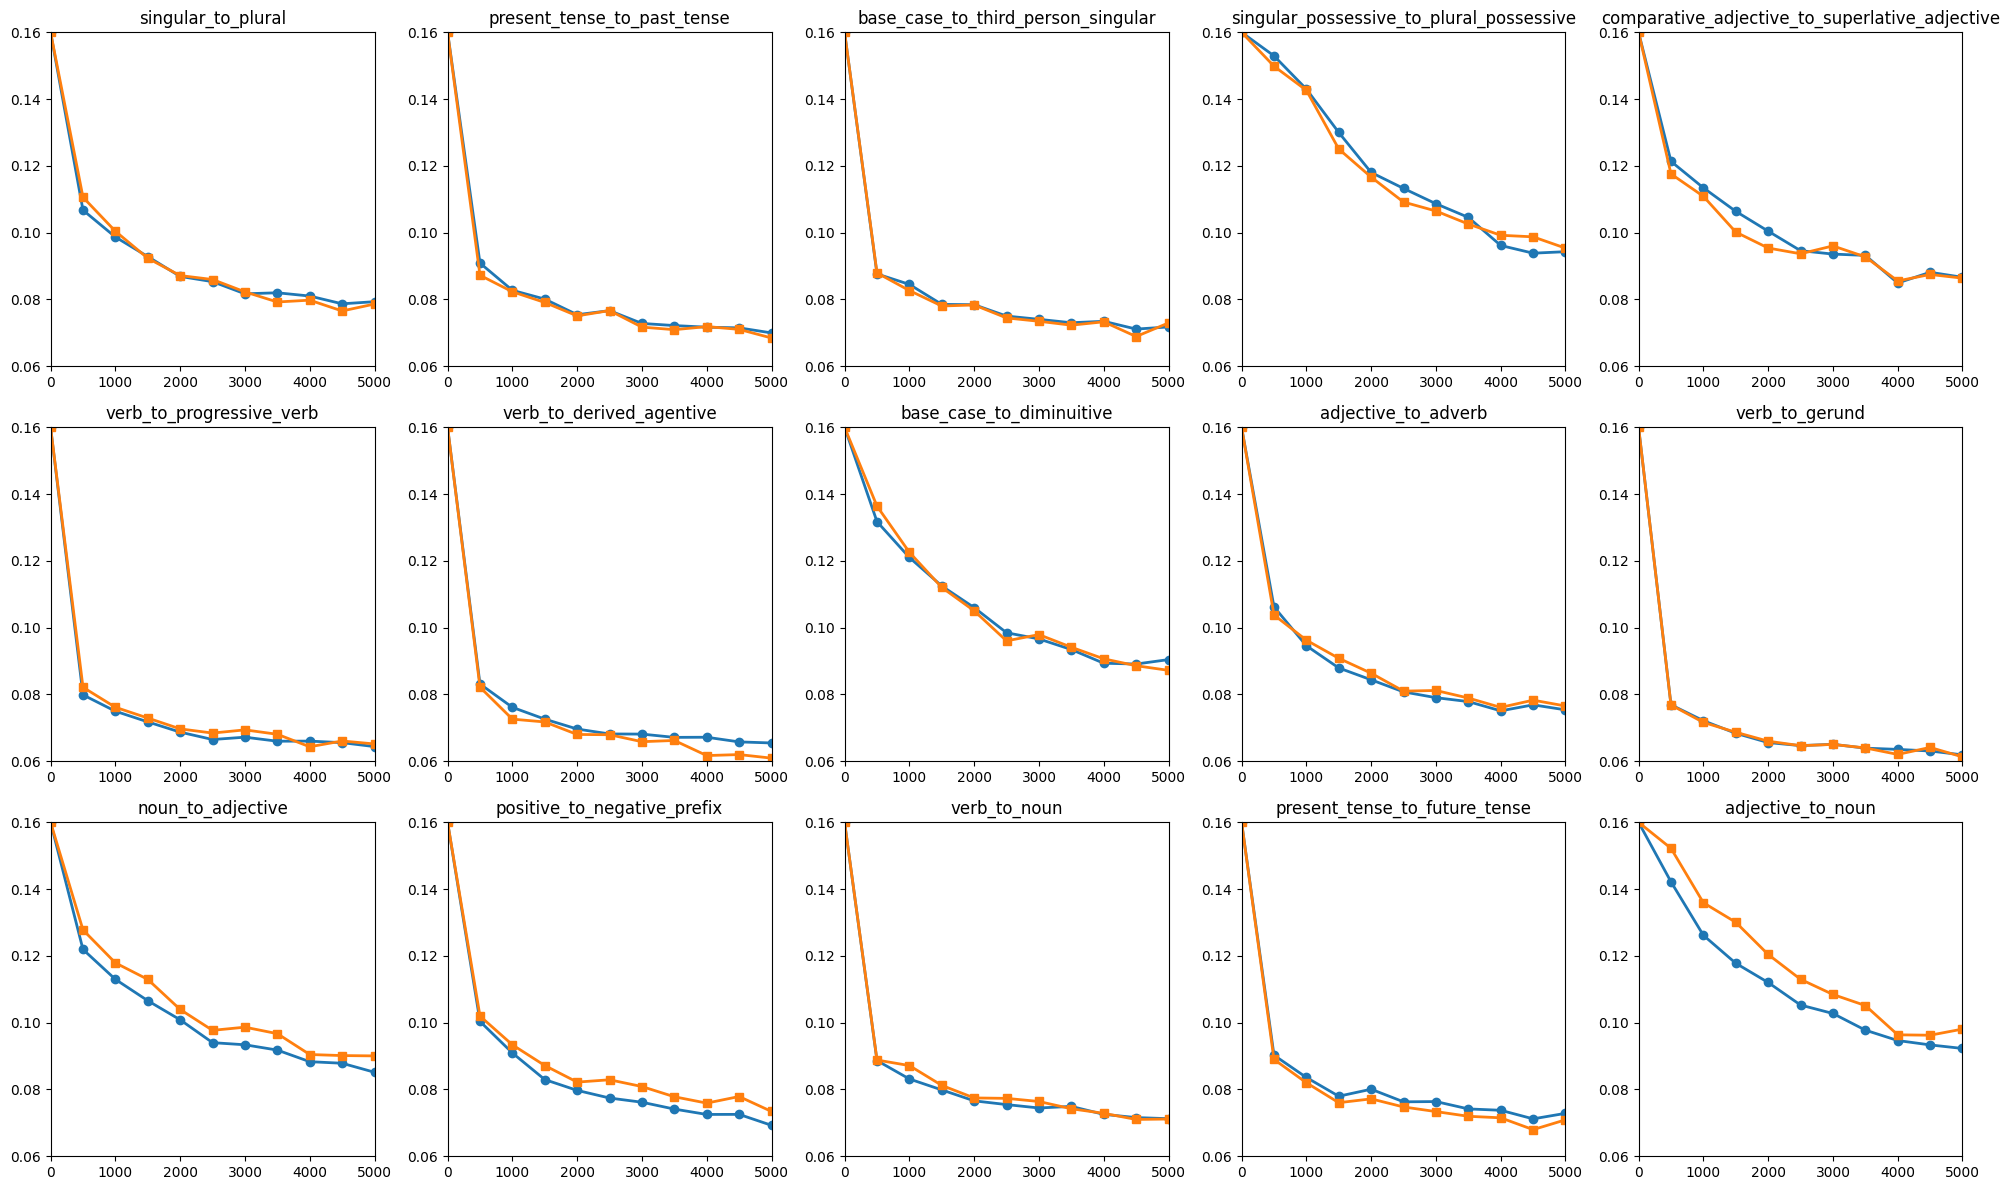

In [67]:
# prompt: Create a 3x5 matplotlib grid. For each morphological transformation in TRAIN_DATA_CATEGORIES, plot the train loss and the validation loss. Multiply the x axis by 500. Remove the x and y axis labels and the numbers on the x and y axis. Use a standardized y axis from 0 to 1 and a standardized x axis from 0 to 5000

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Create a 3x5 grid of subplots

# Assuming 'losses' and 'TRAIN_DATA_CATEGORIES' are defined from previous code
for i, category in enumerate(TRAIN_DATA_CATEGORIES):
    row = i // 5
    col = i % 5
    ax = axes[row, col]

    train_losses = losses['train'][category].copy()
    val_losses = losses['val'][category].copy()

    train_losses.insert(0, 0.16)
    val_losses.insert(0, 0.16)

    x_vals = [x * 500 for x in range(len(train_losses))]
    ax.plot(x_vals, train_losses, label='Train Loss',linewidth=2,  marker='o')
    ax.plot(x_vals, val_losses, label='Validation Loss', linewidth=2, marker='s')

    ax.set_xlim(0, 5000)
    ax.set_ylim(0.06, 0.16)

    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])

    ax.set_title(category)

plt.tight_layout()
plt.show()


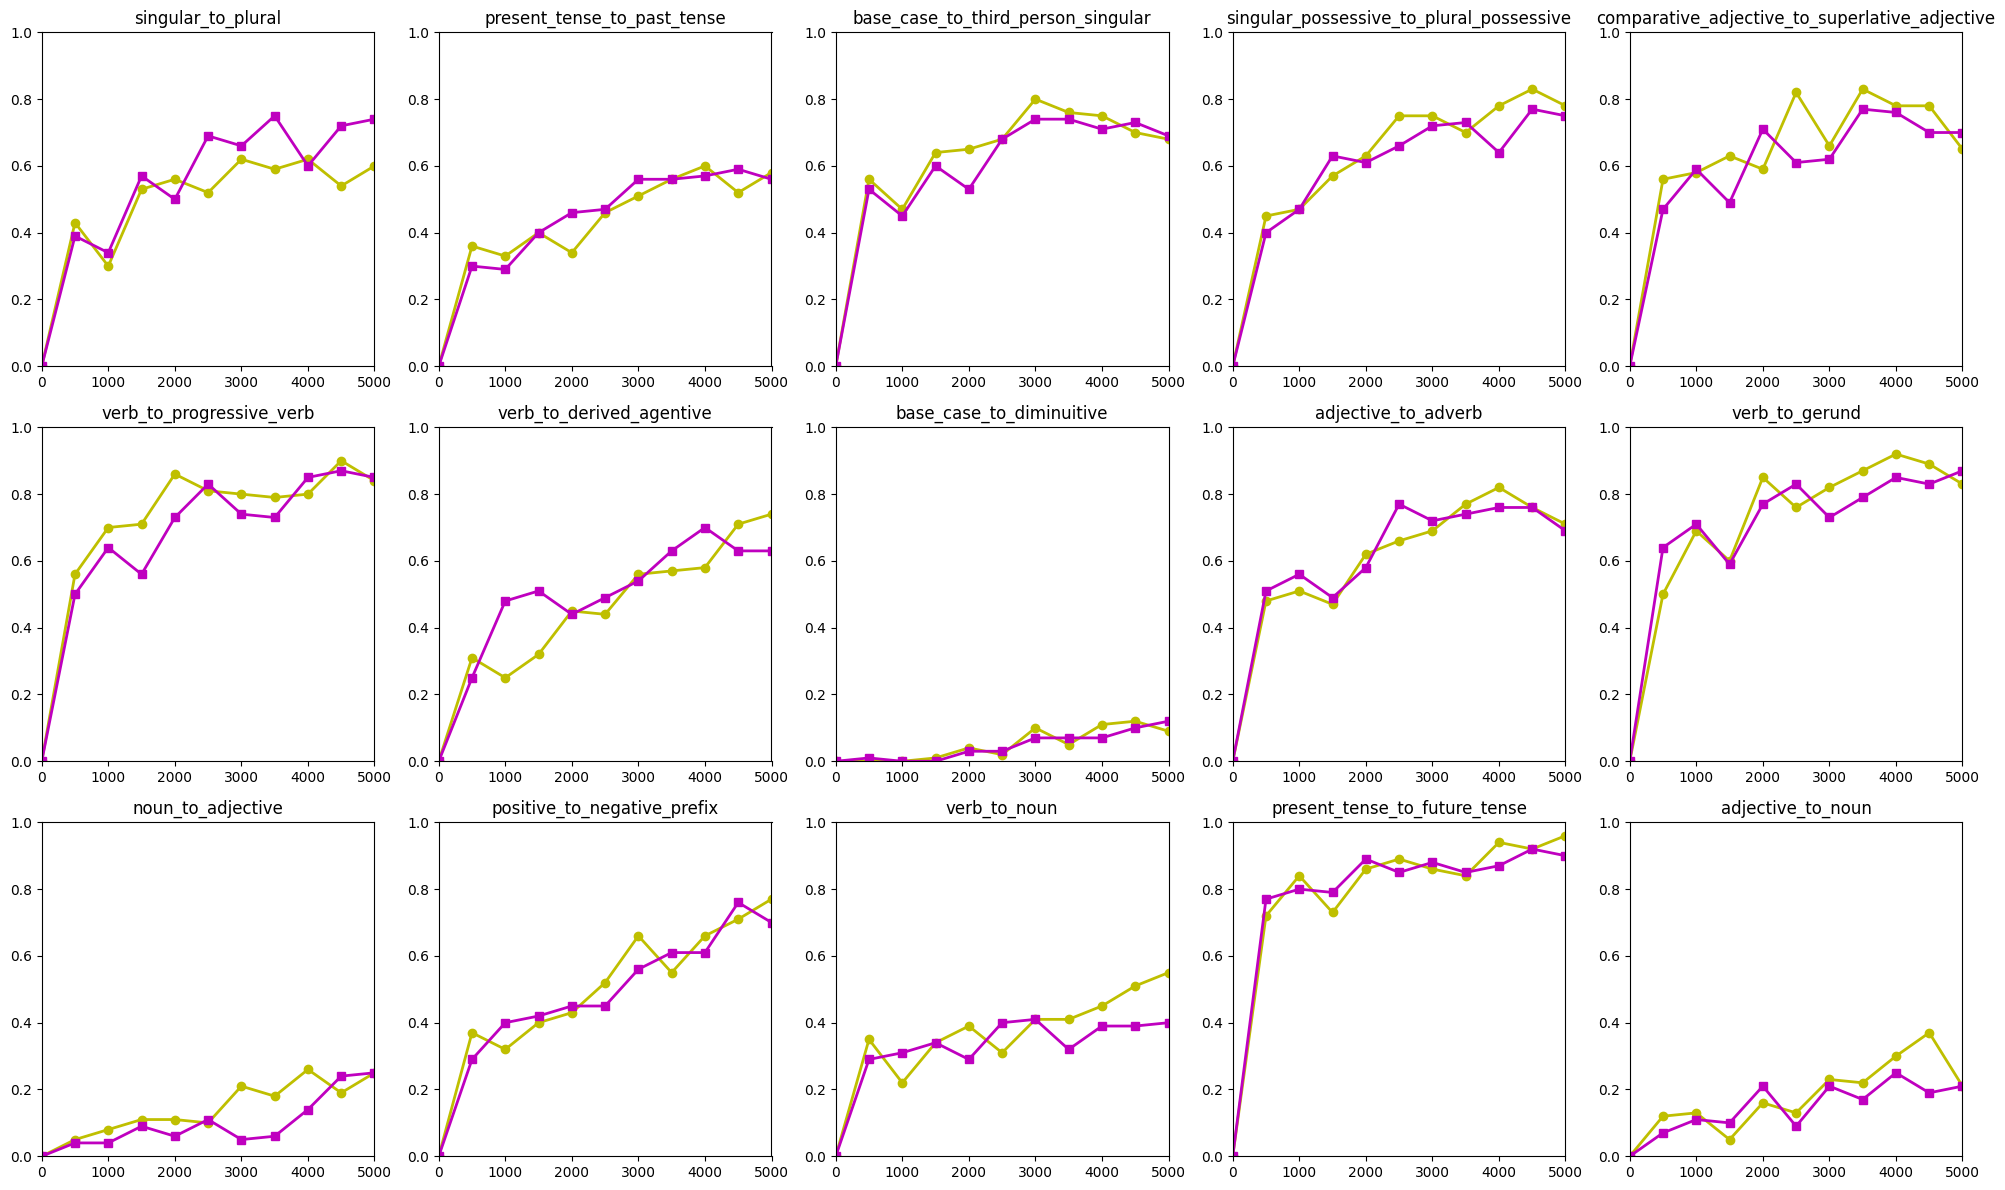

In [88]:
# prompt: Create a 3x5 matplotlib grid. For each morphological transformation in TRAIN_DATA_CATEGORIES, plot the train loss and the validation loss. Multiply the x axis by 500. Remove the x and y axis labels and the numbers on the x and y axis. Use a standardized y axis from 0 to 1 and a standardized x axis from 0 to 5000

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Create a 3x5 grid of subplots

# Assuming 'losses' and 'TRAIN_DATA_CATEGORIES' are defined from previous code
for i, category in enumerate(TRAIN_DATA_CATEGORIES):
    row = i // 5
    col = i % 5
    ax = axes[row, col]

    train_accuracies = accuracies['train'][category].copy()
    val_accuracies = accuracies['val'][category].copy()

    train_accuracies.insert(0, 0)
    val_accuracies.insert(0, 0)

    x_vals = [x * 500 for x in range(len(train_accuracies))]
    ax.plot(x_vals, train_accuracies, label='Train Loss',linewidth=2,  marker='o', color='y')
    ax.plot(x_vals, val_accuracies, label='Validation Loss', linewidth=2, marker='s', color='m')

    ax.set_xlim(0, 5000)
    ax.set_ylim(0, 1)

    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])

    ax.set_title(category)

plt.tight_layout()
plt.show()


In [82]:
# Calculate average validation losses for specified categories




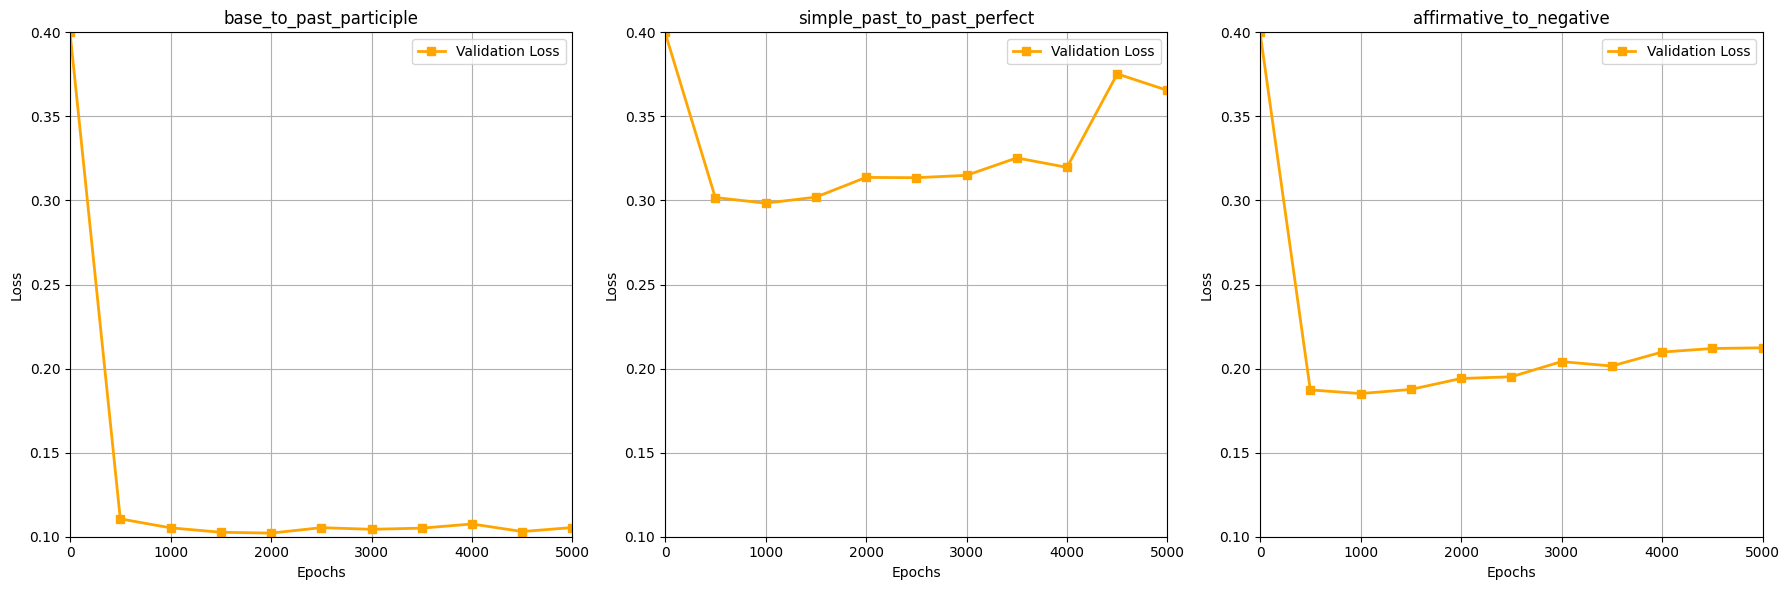

In [87]:
# prompt: Create a 1x3 matplotlib graph. For each category in VAL_CATEGORIES = [
#     'base_to_past_participle',
#     'simple_past_to_past_perfect',
#     'affirmative_to_negative'
# ], plot the validation loss over time
VAL_CATEGORIES = [
    'base_to_past_participle',
    'simple_past_to_past_perfect',
    'affirmative_to_negative'
]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, category in enumerate(VAL_CATEGORIES):
    ax = axes[i]
    val_losses = losses['val'][category].copy()
    val_losses.insert(0, 0.40)
    x_vals = [x * 500 for x in range(len(val_losses))]
    ax.plot(x_vals, val_losses, label='Validation Accuracy', linewidth=2, marker='s', color='orange')
    ax.set_title(category)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0, 5000)
    ax.set_ylim(0.1, 0.4)

plt.tight_layout()
plt.show()


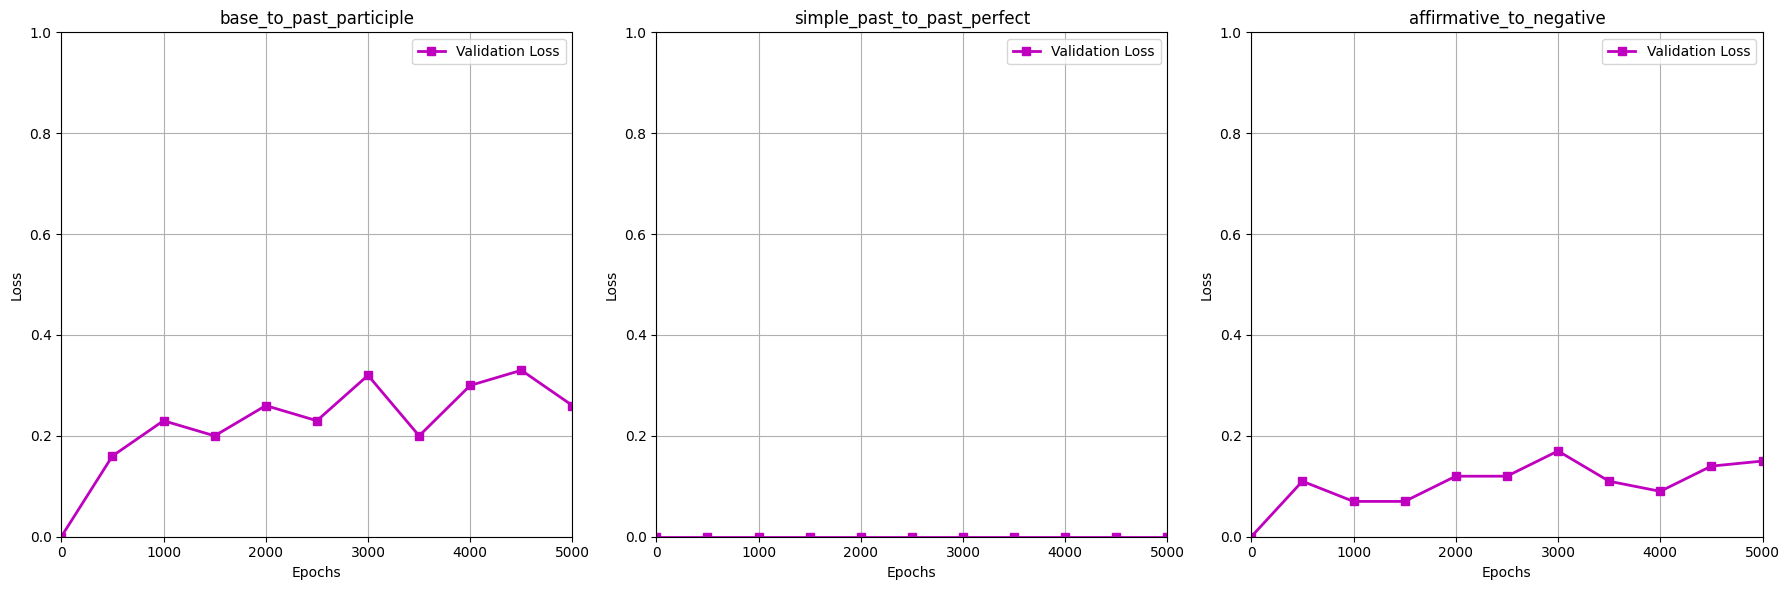

In [90]:
# prompt: Create a 1x3 matplotlib graph. For each category in VAL_CATEGORIES = [
#     'base_to_past_participle',
#     'simple_past_to_past_perfect',
#     'affirmative_to_negative'
# ], plot the validation loss over time
VAL_CATEGORIES = [
    'base_to_past_participle',
    'simple_past_to_past_perfect',
    'affirmative_to_negative'
]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, category in enumerate(VAL_CATEGORIES):
    ax = axes[i]
    val_accuracies = accuracies['val'][category].copy()
    val_accuracies.insert(0, 0)
    x_vals = [x * 500 for x in range(len(val_accuracies))]
    ax.plot(x_vals, val_accuracies, label='Validation Accuracy', linewidth=2, marker='s', color='m')
    ax.set_title(category)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0, 5000)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()
